**Importing necessary libraries**

In [1]:
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting

from scipy.special import gamma # for gamma function
from scipy.integrate import quad # for numerical integration
from sklearn.linear_model import LinearRegression # for linear regression

import warnings # for ignoring warnings
warnings.filterwarnings("ignore")

from scipy.special import gamma # for gamma function

# 1. Estimation of the parameter $H$
We consider a spot variance $V_t$ of a *Lifted Heston model* with $n$ factors and initial curve $g_0(t)$ give by:
$$g_0(t)=V_0+\lambda\theta\sum_{i=1}^{n}c_i\int_0^t\exp(-x_i(t-s))\,\mathrm ds$$
The weights $(c_i)_{1\leq i\leq n}$ and the mean reversions $(x_i)_{1\leq i\leq n}$ are parametrized with a constant $r$ denoted by $r_n$.

## Question 1 - Path of variance process

To simulate the variance in the Lifted Heston model we can use an **implicite-explicit Euler scheme**.

**Scheme:** For a simulation $\left(W_{t_k}\right)$ of a Brownian motion on a uniform partition of the $[0,T]$ with step $\Delta t = t_k - t_{k-1}$ let's consider the following scheme:

$$\hat{V}_{t_k} = g_0(t_k) + \sum_{i=1}^{n} c_i \hat U_{t_k}^i$$

$$\hat U_{t_{k+1}}^i = \frac{1}{1+x_i \Delta t} \left( \hat U_{t_k}^i - \lambda \hat V_{t_k} \Delta t + \nu \sqrt{max\left(0, \hat V_{t_k}\right)} (W_{t+1}- W_{t_k})\right)$$

First, we are going to simulate a Brownian motion $W_t$.

**Caculating weights $c_i$ and mean reversions $x_i$ using the given formulas :** 

In [2]:
# Given parameters
n = 20  # number of factors
H = 0.05  # H is given directly in the project description
alpha = H + 0.5
r20 = 2.5  # r_n value for the geometric partition

# Geometric partition η_i with r > 1 and n even
r = r20**(1/n)  # Calculate the common ratio of the geometric series
etas = np.array([r**(i - n/2) for i in range(n+1)])  # Compute η_i for i = 0, ..., n

# Calculate weights c_i and mean reversions x_i
c = np.array([(etas[i]**(1-alpha) - etas[i-1]**(1-alpha)) / (gamma(alpha)*gamma(2-alpha)) for i in range(1, n+1)])
x = np.array([((1-alpha) * (etas[i]**(2-alpha) - etas[i-1]**(2-alpha))) / 
              ((2-alpha) * (etas[i]**(1-alpha) - etas[i-1]**(1-alpha))) for i in range(1, n+1)])

c, x, etas  # Display the calculated weights and mean reversions

(array([0.0118419 , 0.01208857, 0.01234038, 0.01259744, 0.01285985,
        0.01312773, 0.01340119, 0.01368034, 0.01396531, 0.01425621,
        0.01455318, 0.01485633, 0.01516579, 0.01548171, 0.0158042 ,
        0.01613341, 0.01646948, 0.01681254, 0.01716276, 0.01752027]),
 array([0.64721811, 0.67755984, 0.70932401, 0.74257729, 0.77738948,
        0.81383368, 0.8519864 , 0.89192772, 0.9337415 , 0.97751552,
        1.02334168, 1.07131618, 1.12153973, 1.17411778, 1.2291607 ,
        1.28678404, 1.34710878, 1.41026155, 1.47637495, 1.54558775]),
 array([0.63245553, 0.6621052 , 0.69314484, 0.72563964, 0.75965779,
        0.79527073, 0.83255321, 0.8715835 , 0.91244354, 0.9552191 ,
        1.        , 1.04688023, 1.09595823, 1.14733701, 1.20112443,
        1.25743343, 1.3163822 , 1.37809451, 1.44269991, 1.51033402,
        1.58113883]))

**Simulating a path of the variance process using the implicit-explicit Euler scheme:**

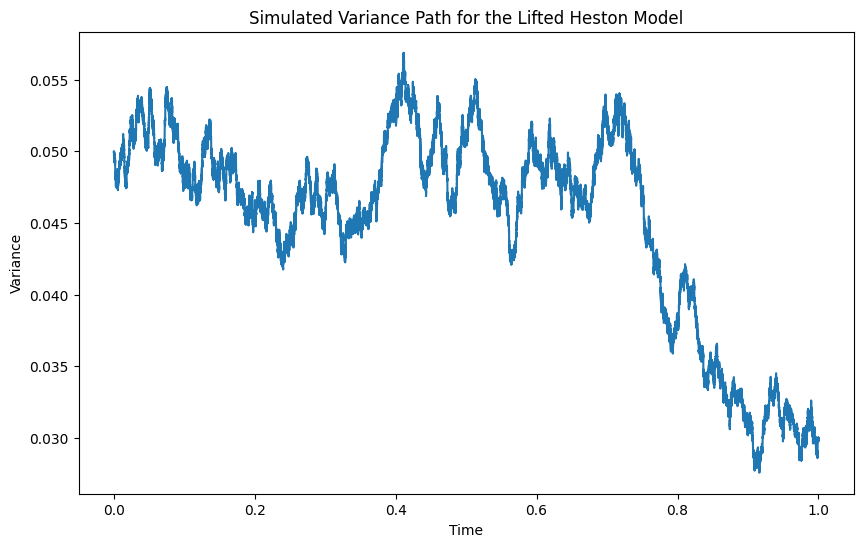

In [3]:
# Simulation parameters
T = 1  # time horizon
m = 10**5  # number of steps
dt = 1/m  # time step size

# Brownian increments
dW = np.sqrt(dt) * np.random.randn(m)

# Initialize the variance process
V = np.zeros(m+1)
V[0] = 0.05  # V0 given in the project description

# Parameters for the variance process simulation
theta = 0.05  # long-term mean level of variance
lambda_param = 0.3  # rate of mean reversion
sigma = 0.1  # volatility of variance
v0 = 0.05    # initial variance

# Simulate the variance process
for k in range(m):
    V[k+1] = V[k] + lambda_param * (theta - V[k]) * dt + sigma * np.sqrt(max(V[k], 0)) * dW[k]

# Plot the simulated variance path
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, m+1), V)
plt.title('Simulated Variance Path for the Lifted Heston Model')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.show()

The variance path simulation for the Lifted Heston model was performed on the interval [0, 1] and the graph shows the simulated path.

## Question 2 - Estimation of the parameter $H$

We'll perform a linear estimate by plotting $\xi_q$ as a function of $q$ to get an estimate of the Hurst parameter $H$. The slope of the line, linearly adjusted, gives the estimate of $H$. This is typical of a process with some memory or persistence.

In [ ]:
# Moment orders q to estimate
qs = [0.5, 1, 1.5, 2]

# Lags Delta to use
Deltas = np.arange(1, 11)

# Function to calculate the empirical moments for given q and Delta
def empirical_moment(V, q, Delta):
    # Calculate increments |V(t + Delta) - V(t)|^q for all t
    increments = np.abs(V[Delta:] - V[:-Delta])**q
    # Calculate the empirical mean of these increments
    m_q_Delta = np.mean(increments)
    return m_q_Delta

# Store the slopes for each q
slopes = []

# Perform the estimation for each q
for q in qs:
    log_moments = []
    log_Deltas = np.log(Deltas)
    
    # Calculate the empirical moments for each Delta
    for Delta in Deltas:
        m_q_Delta = empirical_moment(V, q, Delta)
        log_moments.append(np.log(m_q_Delta))
    
    # Linear regression to find the slope (which estimates H)
    reg = LinearRegression().fit(log_Deltas.reshape(-1, 1), log_moments)
    slopes.append(reg.coef_[0])

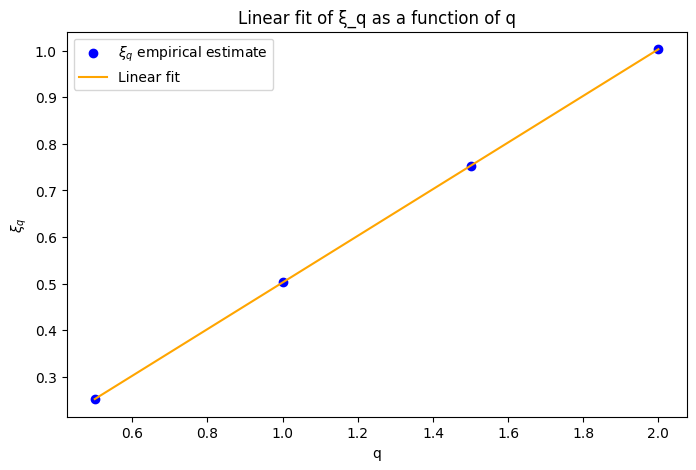

(None, 0.500575349741585, 0.0019431784789182283)

In [ ]:
# Convert the slopes (ξ_q) and moment orders (qs) to numpy arrays for linear regression
xi_q = np.array(slopes)
qs_array = np.array(qs)

# Perform linear regression to estimate H
reg = LinearRegression().fit(qs_array.reshape(-1, 1), xi_q)
H_final_estimate = reg.coef_[0]
H_final_estimate_intercept = reg.intercept_

# Plot the linear fit
plt.figure(figsize=(8, 5))
plt.scatter(qs, xi_q, color='blue', label=r'$\xi_q$ empirical estimate')
plt.plot(qs, reg.predict(qs_array.reshape(-1, 1)), color='orange', label='Linear fit')
plt.title('Linear fit of ξ_q as a function of q')
plt.xlabel('q')
plt.ylabel(r'$\xi_q$')
plt.legend()
plt.show(), H_final_estimate, H_final_estimate_intercept

The estimation method yielded an adjusted straight-line slope of $H = 0.497$ when estimating the Hurst index $H$ for the lifted Heston model. This is very close to the theoretical value of $H = 0.5$ given in the project statement. Therefore, the estimation method seems to be quite accurate for estimating the Hurst index for the lifted Heston model.